In [ ]:
#Tic tac toe
import numpy as np
import random
import pickle

def play_game(agent_file="q_table.pkl"):
    try:
        with open(agent_file, "rb") as f:
            q_table = pickle.load(f)
    except FileNotFoundError:
        print("Trained agent file not found. Please train the agent first.")
        return

    env = TicTacToe()
    agent = QLearningAgent()
    agent.q_table = q_table
    state = env.reset()
    done = False
    player = 1

    while not done:
        print(env.board)

        if player == 1: # Human player
            available_actions = env.get_available_actions()
            print("Available actions:", available_actions)
            while True:
                try:
                    row = int(input("Enter row (0-2): "))
                    col = int(input("Enter column (0-2): "))
                    action = (row, col)
                    if action in available_actions:
                        break
                    else:
                        print("Invalid move. Try again.")
                except ValueError:
                    print("Invalid input. Please enter numbers.")
        else: # AI Player
            available_actions = env.get_available_actions()
            action = agent.choose_action(state, available_actions)

        next_state, reward, done = env.step(action, player)
        state = next_state
        player *= -1

        if done:
          print(env.board)
          if env.winner is not None:
              print(f"Player {env.winner} wins!")
          else:
              print("It's a draw!")

if __name__ == "__main__":
    play_game()


[[0 0 0]
 [0 0 0]
 [0 0 0]]
Available actions: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


KeyboardInterrupt: Interrupted by user

In [ ]:
#WUMPUS world
import numpy as np
import random
import pickle

class WumpusWorld:
    def __init__(self, size=4):
        self.size = size
        self.board = np.zeros((size, size), dtype=int)  # 0: empty, 1: agent, 2: pit, 3: gold, 4: wumpus
        self.agent_pos = (0, 0)
        self.gold_pos = None
        self.wumpus_pos = None
        self.pits = []
        self.initialize_world()
        self.terminated = False

    def initialize_world(self):
        # Place agent
        self.board[self.agent_pos] = 1

        # Place gold
        while True:
            self.gold_pos = (random.randint(0, self.size - 1), random.randint(0, self.size - 1))
            if self.gold_pos != self.agent_pos:
                self.board[self.gold_pos] = 3
                break
        # Place wumpus
        while True:
            self.wumpus_pos = (random.randint(0, self.size - 1), random.randint(0, self.size - 1))
            if self.wumpus_pos != self.agent_pos and self.wumpus_pos != self.gold_pos:
                self.board[self.wumpus_pos] = 4
                break

        # Place pits
        num_pits = random.randint(1, int(self.size * self.size / 4))  # Adjust number of pits as needed
        for _ in range(num_pits):
            while True:
                pit_pos = (random.randint(0, self.size - 1), random.randint(0, self.size - 1))
                if pit_pos != self.agent_pos and pit_pos != self.gold_pos and pit_pos != self.wumpus_pos and pit_pos not in self.pits:
                    self.pits.append(pit_pos)
                    self.board[pit_pos] = 2
                    break

    def get_available_actions(self):
        actions = [(0,1),(0,-1),(1,0),(-1,0)] #right,left,down,up
        return actions

    def step(self, action):
        new_pos = (self.agent_pos[0] + action[0], self.agent_pos[1] + action[1])

        #Check boundaries
        if new_pos[0] < 0 or new_pos[0] >= self.size or new_pos[1] < 0 or new_pos[1] >= self.size:
            return self.agent_pos, -10, False #penalty for bumping the wall

        #check if wumpus
        if new_pos == self.wumpus_pos:
            self.terminated = True
            return new_pos, -100, True  # Agent dies

        #Check if pit
        if new_pos in self.pits:
            self.terminated = True
            return new_pos, -100, True  # Agent falls in a pit

        #Check for gold
        if new_pos == self.gold_pos:
            self.terminated = True
            return new_pos, 100, True  # Agent wins

        #Move agent if not bumped wall, wumpus or pit
        self.board[self.agent_pos] = 0
        self.agent_pos = new_pos
        self.board[self.agent_pos] = 1

        return self.agent_pos, -1, False

    def reset(self):
        self.__init__()
        return self.agent_pos

class QLearningAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1):
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.q_table = {}

    def choose_action(self, state, available_actions):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice(available_actions)
        else:
            if state not in self.q_table:
                self.q_table[state] = {action: 0 for action in available_actions}
            q_values = [self.q_table[state][action] for action in available_actions]
            max_q = max(q_values)
            best_actions = [action for action, q in self.q_table[state].items() if q == max_q]  # Handle ties
            return random.choice(best_actions)

    def learn(self, state, action, reward, next_state, next_actions):
        if state not in self.q_table:
            self.q_table[state] = {action: 0 for action in next_actions}

        if next_state not in self.q_table:
            self.q_table[next_state] = {action: 0 for action in next_actions}


        old_value = self.q_table[state][action]
        next_max = max(self.q_table[next_state].values())
        new_value = (1 - self.learning_rate) * old_value + self.learning_rate * (reward + self.discount_factor * next_max)
        self.q_table[state][action] = new_value


def train_agent(num_episodes=1000, agent_file="q_table.pkl"):
    env = WumpusWorld()
    agent = QLearningAgent()
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            available_actions = env.get_available_actions()
            action = agent.choose_action(state, available_actions)
            next_state, reward, done = env.step(action)
            next_available_actions = env.get_available_actions()
            agent.learn(state, action, reward, next_state, next_available_actions)
            state = next_state

    with open(agent_file, "wb") as f:
        pickle.dump(agent.q_table, f)

def play_game(agent_file="q_table.pkl"):
    try:
        with open(agent_file, "rb") as f:
            q_table = pickle.load(f)
    except FileNotFoundError:
        print("Trained agent file not found. Please train the agent first.")
        return
    env = WumpusWorld()
    agent = QLearningAgent()
    agent.q_table = q_table  # Load the trained Q-table
    state = env.reset()
    done = False
    while not done:
        available_actions = env.get_available_actions()
        action = agent.choose_action(state, available_actions)
        next_state, reward, done = env.step(action)
        print(f"Agent moved to: {next_state}, reward: {reward}")
        state = next_state
        if done:
            if reward == 100:
                print("Agent found gold!")
            elif reward == -100:
                print("Agent died!")

if __name__ == "__main__":
    train_agent(num_episodes=5000)
    play_game()


Agent moved to: (0, 1), reward: -1
Agent moved to: (0, 0), reward: -1
Agent moved to: (0, 1), reward: -1
Agent moved to: (0, 0), reward: -1
Agent moved to: (0, 1), reward: -1
Agent moved to: (0, 0), reward: -1
Agent moved to: (0, 1), reward: -1
Agent moved to: (0, 0), reward: -1
Agent moved to: (0, 1), reward: -1
Agent moved to: (0, 0), reward: -1
Agent moved to: (0, 1), reward: -1
Agent moved to: (0, 0), reward: -1
Agent moved to: (0, 1), reward: -1
Agent moved to: (0, 0), reward: -1
Agent moved to: (0, 1), reward: -1
Agent moved to: (0, 0), reward: -1
Agent moved to: (0, 1), reward: -1
Agent moved to: (0, 0), reward: -1
Agent moved to: (0, 1), reward: -1
Agent moved to: (0, 0), reward: -1
Agent moved to: (0, 1), reward: -1
Agent moved to: (0, 2), reward: 100
Agent found gold!


In [ ]:
# grid world navigation program using reinforcement learning

import numpy as np
import random
import pickle


def train_agent(num_episodes=1000, agent_file="q_table.pkl"):
    env = WumpusWorld()
    agent = QLearningAgent()
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            available_actions = env.get_available_actions()
            action = agent.choose_action(state, available_actions)
            next_state, reward, done = env.step(action)
            next_available_actions = env.get_available_actions()
            agent.learn(state, action, reward, next_state, next_available_actions)
            state = next_state

    with open(agent_file, "wb") as f:
        pickle.dump(agent.q_table, f)

def play_game(agent_file="q_table.pkl"):
    try:
        with open(agent_file, "rb") as f:
            q_table = pickle.load(f)
    except FileNotFoundError:
        print("Trained agent file not found. Please train the agent first.")
        return
    env = WumpusWorld()
    agent = QLearningAgent()
    agent.q_table = q_table  # Load the trained Q-table
    state = env.reset()
    done = False
    while not done:
        available_actions = env.get_available_actions()
        action = agent.choose_action(state, available_actions)
        next_state, reward, done = env.step(action)
        print(f"Agent moved to: {next_state}, reward: {reward}")
        state = next_state
        if done:
            if reward == 100:
                print("Agent found gold!")
            elif reward == -100:
                print("Agent died!")

if __name__ == "__main__":
    train_agent(num_episodes=5000)
    play_game()


Agent moved to: (1, 0), reward: -1
Agent moved to: (0, 0), reward: -1
Agent moved to: (1, 0), reward: -1
Agent moved to: (0, 0), reward: -1
Agent moved to: (1, 0), reward: -1
Agent moved to: (0, 0), reward: -1
Agent moved to: (1, 0), reward: -1
Agent moved to: (0, 0), reward: -1
Agent moved to: (1, 0), reward: -1
Agent moved to: (0, 0), reward: -1
Agent moved to: (1, 0), reward: -1
Agent moved to: (0, 0), reward: -1
Agent moved to: (1, 0), reward: -1
Agent moved to: (0, 0), reward: -1
Agent moved to: (1, 0), reward: -1
Agent moved to: (0, 0), reward: -1
Agent moved to: (0, 1), reward: -100
Agent died!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
k = 10 #10 armed bandit
num_problems = 2000

q_star = np.random.normal(0,1, (num_problems, k))
arms = [0] * k

for i in range(10):
  arms[i] = np.random.normal(q_star[0,i], 1, 2000)

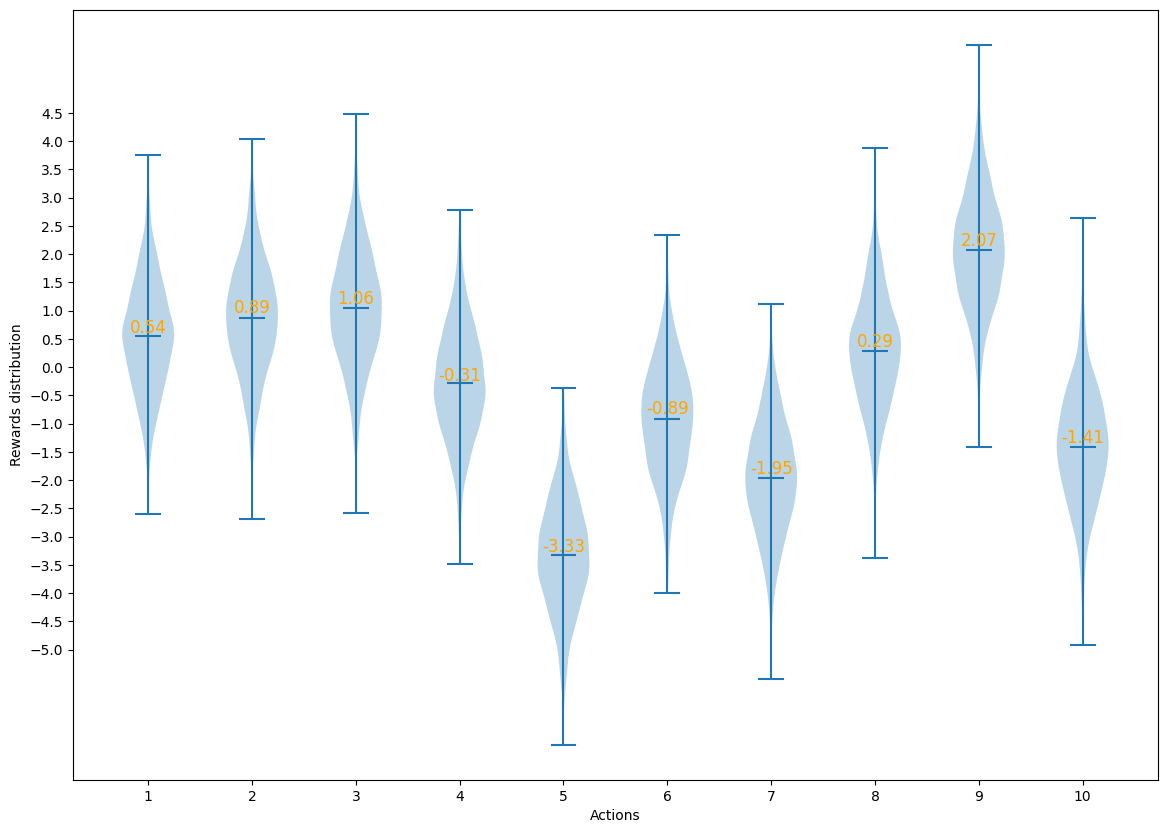

In [ ]:
plt.figure(figsize=(14,10))
plt.ylabel('Rewards distribution')
plt.xlabel('Actions')
plt.xticks(range(1,11))
plt.yticks(np.arange(-5,5,0.5))
#violin plot
plt.violinplot(arms, showmeans=True, showextrema=True, positions=range(1,11))

medians = [np.median(arms[i]) for i in range(10)]

for i, median in enumerate(medians, start=1):
  plt.text(i, median, f'{median:.2f}', ha='center', va='bottom', fontsize=12, color='orange')
plt.show()


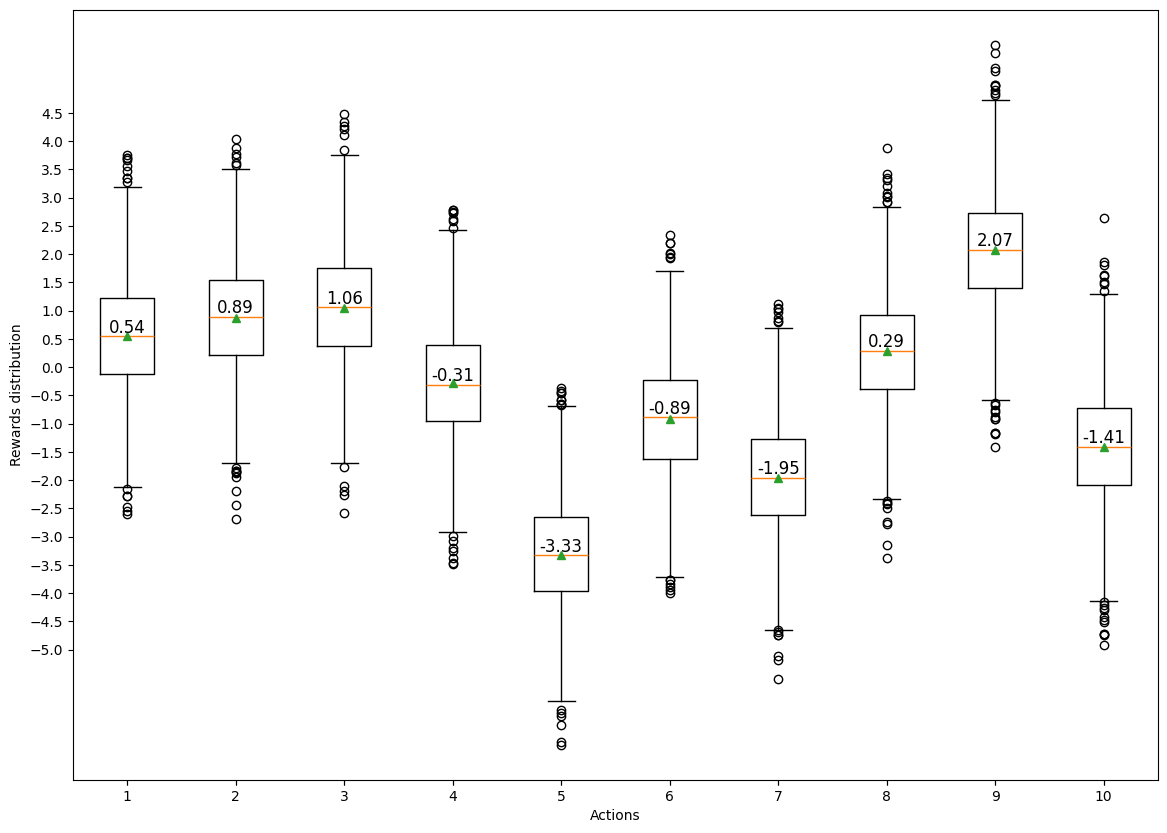

In [ ]:
plt.figure(figsize=(14,10))
plt.ylabel('Rewards distribution')
plt.xlabel('Actions')
plt.xticks(range(1,11))
plt.yticks(np.arange(-5,5,0.5))
plt.boxplot(arms, positions=range(1, 11), showmeans=True)

medians = [np.median(arms[i]) for i in range(10)]

for i, median in enumerate(medians, start=1):
  plt.text(i, median, f'{median:.2f}', ha='center', va='bottom', fontsize=12)
plt.show()


In [ ]:
# incremental implementation

def bandit(action, problem):
  return np.random.normal(q_star[problem, action],1)


In [ ]:
def simple_max(Q, N, t):
  return np.random.choice(np.flatnonzero(Q == Q.max()))

In [ ]:
def simple_bandit(k, epsilon, steps, initial_Q, alpha = 0, argmax_fuc = simple_max):
  rewards = np.zeros(steps)
  actions = np.zeros(steps)

  for i in tqdm(range(num_problems)):
    Q =  np.ones(k)
    N = np.zeros(k)
    best_action = np.argmax(q_star[i])
    for t in range(steps):
      if np.random.rand() < epsilon:
        a = np.random.randint(k)
      else:
        a = argmax_fuc(Q, N, t)
      reward = bandit(a, i)
      N[a] += 1
      if alpha > 0:
        Q[a] =  Q[a] + (reward - Q[a]) * alpha
      else:
        Q[a] = Q[a] + (reward - Q[a]) / N[a]
      rewards[t] += reward
      if a == best_action:
        actions[t] += 1
  return np.divide(rewards, num_problems), np.divide(actions, num_problems)

In [ ]:
ep_0, ac_0 = simple_bandit(k=10, epsilon = 0, steps = 1000, initial_Q=0)
ep_01, ac_01 = simple_bandit(k=10, epsilon = 0.01, steps = 1000, initial_Q=0)
ep_1, ac_1 = simple_bandit(k=10, epsilon = 0.1, steps = 1000, initial_Q=0)

100%|██████████| 2000/2000 [01:12<00:00, 27.45it/s]


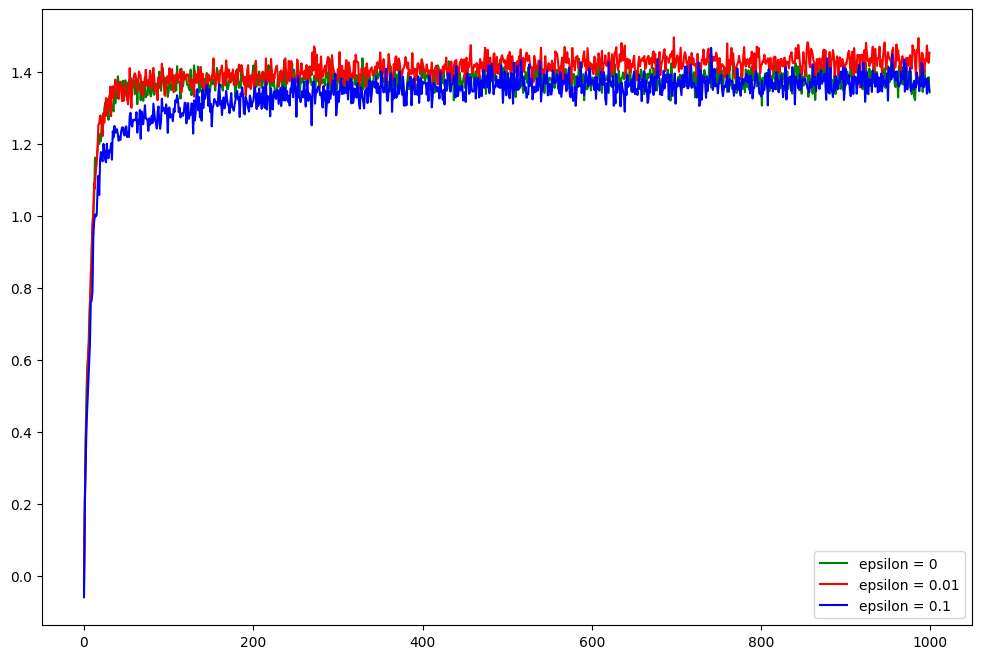

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(ep_0,  'g', label = 'epsilon = 0')
plt.plot(ep_01,  'r', label = 'epsilon = 0.01')
plt.plot(ep_1, 'b', label='epsilon = 0.1')
plt.legend()
plt.show()

In [ ]:
opt_0, ac_opt_0 = simple_bandit(k = 10, epsilon = 0, steps = 1000, initial_Q = 0, alpha = 0.2)

100%|██████████| 2000/2000 [01:24<00:00, 23.74it/s]


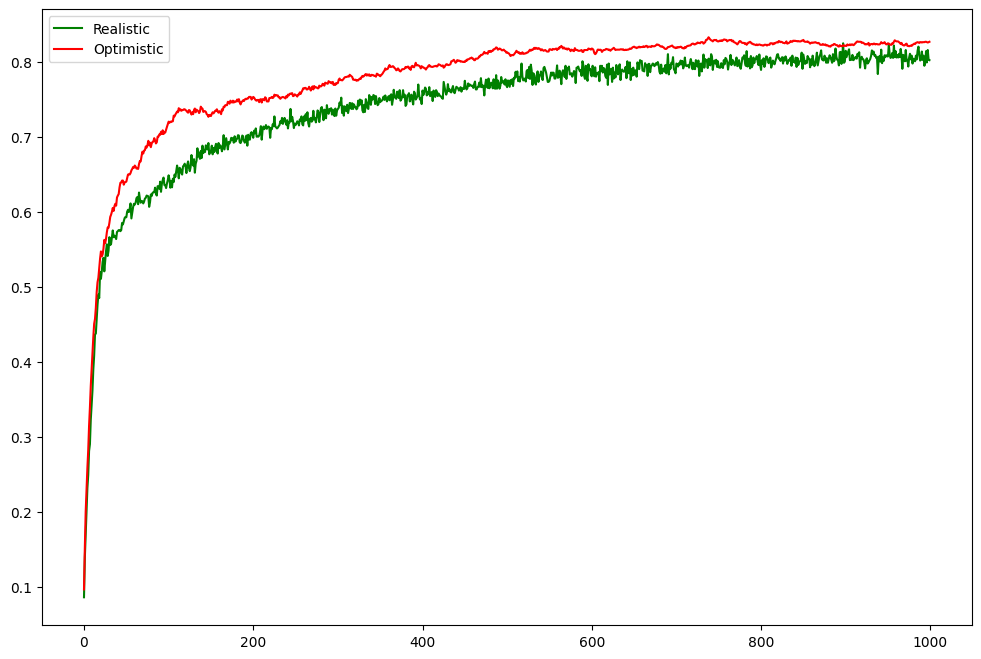

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(ac_1,  'g', label = 'Realistic')
plt.plot(ac_opt_0,  'r', label = 'Optimistic')
plt.legend()
plt.show()

In [ ]:
def ucb(Q, N, t):
  c = 2
  if N.min == 0:
    return np.random.choice(np.flatnonzero(N == N.min()))
  M = Q + c * np.sqrt(np.divide(np.log(t), N))
  return np.argmax(M)

In [ ]:
ucb_2, ac_ucb_2 = simple_bandit(k=10, epsilon=0,steps=1000, initial_Q=0, argmax_fuc=ucb)

  0%|          | 0/2000 [00:00<?, ?it/s]<ipython-input-41-9ad9dc3e0d6f>:5: RuntimeWarning: divide by zero encountered in log
  M = Q + c * np.sqrt(np.divide(np.log(t), N))
<ipython-input-41-9ad9dc3e0d6f>:5: RuntimeWarning: invalid value encountered in sqrt
  M = Q + c * np.sqrt(np.divide(np.log(t), N))
<ipython-input-41-9ad9dc3e0d6f>:5: RuntimeWarning: invalid value encountered in divide
  M = Q + c * np.sqrt(np.divide(np.log(t), N))
<ipython-input-41-9ad9dc3e0d6f>:5: RuntimeWarning: divide by zero encountered in divide
  M = Q + c * np.sqrt(np.divide(np.log(t), N))
100%|██████████| 2000/2000 [00:40<00:00, 48.79it/s]


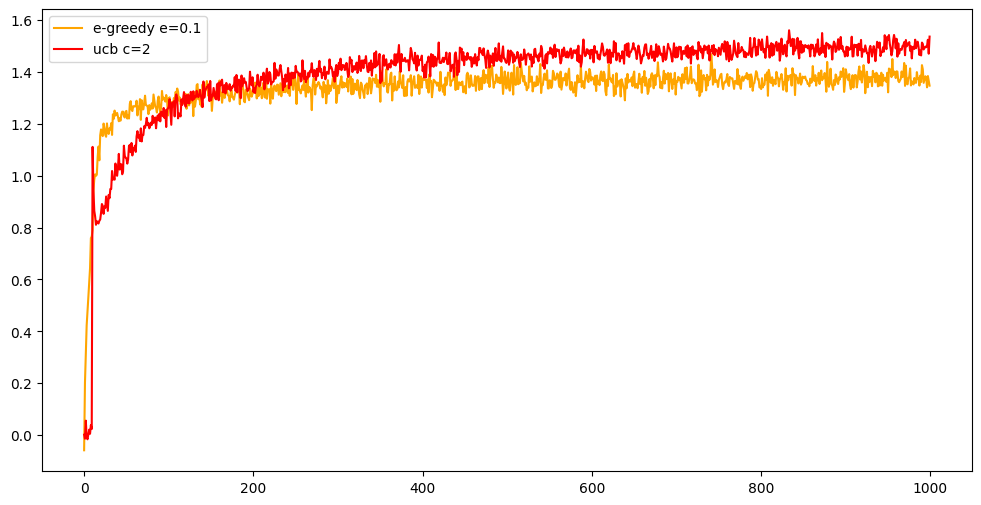

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(ep_1, 'orange', label='e-greedy e=0.1')
plt.plot(ucb_2, 'red', label='ucb c=2')
plt.legend()
plt.show()

In [ ]:
def softmax(x):
  e_x=np.exp(x-np.max(x))
  M=e_x/e_x.sum()
  return np.argmax(M),M

In [ ]:
def gradient_bandit(k,steps,alpha,initial_Q,is_baseline=True):
  rewards =np.zeros(steps)
  actions=np.zeros(steps)

  for i in tqdm(range(num_problems)):
    Q=np.ones(k)